In [41]:
import acl
import numpy as np
from PIL import Image, ImageDraw
from acl_sample import Sample
import struct
from constant import NPY_BYTE, ACL_MEMCPY_DEVICE_TO_HOST, ACL_MEM_MALLOC_NORMAL_ONLY, ACL_MEMCPY_HOST_TO_DEVICE
from postprocessing import postprocess_boxes
import cv2
import matplotlib.pyplot as plt

In [42]:
device_id = 0
input_size = 608
model_path = "./model/yolov3_caffe_608.om"
img_dict = {"path": "./data/shot.jpg", "dtype": np.uint8}

In [43]:
sample = Sample(device_id,
                model_path,
                input_size,
                input_size)

[Sample] init resource stage:
[Sample] init resource stage success
[Model] class Model init resource stage:
结构 94576199079408
input number:2
input 1: 16
[Model] create model output dataset:
[Model] create model output dataset success
[Model] class Model init resource stage success
[Model] class Model release source success
[Dvpp] class Dvpp exist success
[Sample] class Sample release source success


In [44]:
# %timeit -n 100 -r 10
model_output = sample.forward(img_dict)

[Sample] width:1920 height:1080
[Sample] image:./data/shot.jpg
[Dvpp] vpc decode stage:
decode_out_buffer_size: 3133440
temp_width:%d,temp_height:$d 1920 1080
[Dvpp] vpc decode stage success
[Dvpp] vpc resize stage:
decode_out_buffer_size: 3133440
temp_width:%d,temp_height:$d 1920 1080
decode_out_buffer_size: 554496
temp_width:%d,temp_height:$d 608 608
[Dvpp] crop and paste roi config success
[Dvpp] vpc resize stage success
17729626046464 554496
[Model] create model input dataset:
input2 [ 608.  608. 1080. 1920.], size:4
[Model] create model input dataset success
[Model] execute stage:
[Model] execute stage success
result ouput 1
{'x1': 356.25, 'y1': 454.5, 'x2': 444.25, 'y2': 513.0, 'detection_scores': 0.51171875, 'detection_classes': 32.0}
result [ 3.5625000e+02  4.5450000e+02  4.4425000e+02 ... -1.2011719e-01
  1.6796875e+00 -1.9177246e-01]
[RESULT]  num_detections:  1
[RESULT]  result:  1
[RESULT]  detection_classes:  32.0
[RESULT]  detection_scores:  0.51171875
[RESULT]  detection

In [45]:
acl.mdl.get_dataset_num_buffers(model_output)

2

In [46]:
def get_model_output_by_index(model_output, i, num_classes = 80):
    temp_output_buf = acl.mdl.get_dataset_buffer(model_output, i)

    infer_output_ptr = acl.get_data_buffer_addr(temp_output_buf)
    infer_output_size = acl.get_data_buffer_size(temp_output_buf)
    print("infer_output_size", infer_output_size)
    
    output_host, _ = acl.rt.malloc_host(infer_output_size)
    acl.rt.memcpy(output_host, infer_output_size, infer_output_ptr,
                          infer_output_size, ACL_MEMCPY_DEVICE_TO_HOST)
    
    result = acl.util.ptr_to_numpy(output_host, (infer_output_size,), NPY_BYTE)
    return np.array(struct.unpack(f"{infer_output_size//4}f", bytearray(result)), dtype=np.float32)
# .reshape(-1, 255)

In [47]:
temp_output_buf = acl.mdl.get_dataset_buffer(model_output, 1)

infer_output_ptr = acl.get_data_buffer_addr(temp_output_buf)
infer_output_size = acl.get_data_buffer_size(temp_output_buf)
print("infer_output_size", infer_output_size)

output_host, _ = acl.rt.malloc_host(infer_output_size)
acl.rt.memcpy(output_host, infer_output_size, infer_output_ptr,
                      infer_output_size, ACL_MEMCPY_DEVICE_TO_HOST)

result = acl.util.ptr_to_numpy(output_host, (infer_output_size,), NPY_BYTE)
box_out_num = struct.unpack(f"{infer_output_size//4}I", bytearray(result))

infer_output_size 32


In [48]:
box_out = get_model_output_by_index(model_output, 0)

infer_output_size 24576


In [49]:
box_out_num

(1,
 1425036528,
 1425036528,
 1425036528,
 1425036528,
 1425036528,
 1425036528,
 1425036528)

In [50]:
objNum = box_out_num[0]
boxes = []
for k in range(objNum):
    pos = 0
    leftTopX = box_out[objNum * (pos) + k]
    pos += 1
    leftTopY = box_out[objNum * (pos) + k]
    pos += 1
    rightBotX = box_out[objNum * (pos) + k]
    pos += 1
    rightBotY = box_out[objNum * (pos) + k]
    pos += 1
    confidence = box_out[objNum * (pos) + k]
    pos += 1
    classId = box_out[objNum * (pos) + k]
    pos += 1
    print(leftTopX, leftTopY, rightBotX, rightBotY, confidence, classId)
    boxes.append([leftTopX, leftTopY, rightBotX, rightBotY])

356.25 454.5 444.25 513.0 0.51171875 32.0


In [51]:
img = Image.open(img_dict["path"])

In [52]:
img1 = ImageDraw.Draw(img)
for box in boxes:
    img1.rectangle(box, outline ="blue", width=4)

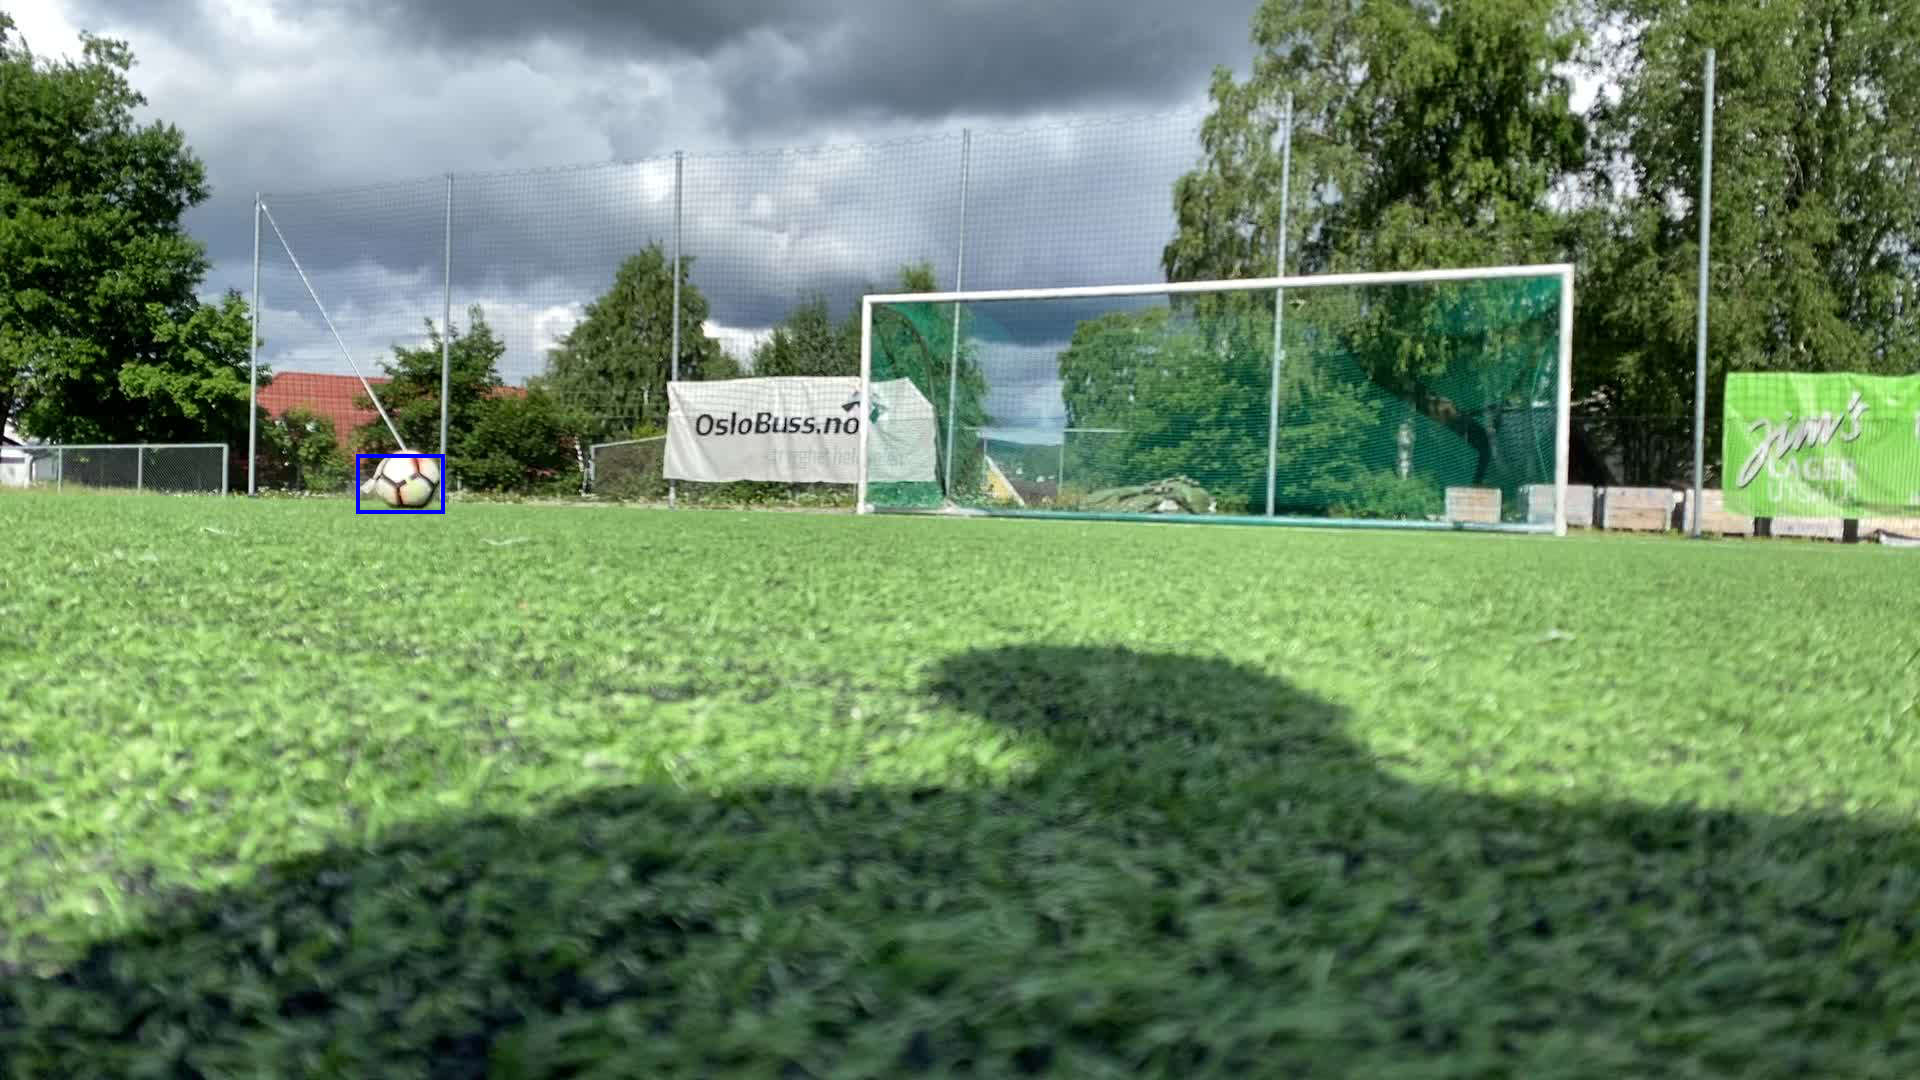

In [53]:
img